# A first model of SNP data

**Please consider having a look at application_MNIST.ipynb before reading this notebook to have more context on the model**

Before moving on to a full dataset, we train our model on a a small subset of SNP. This allows for quick experimentation and for grasping the challenges faced when analyzing this type of data. The SNP modeled are sampled randomly from chromosome 21. We sample 10K SNP and train for 2k SNP at a time to reduce training time even further. This sample is merely a snapshot of the data. In this dataset disease related phenotypes are not available, we therefore use **Super_Population as a target phenotype**. We also add complementary information such as gender and Phase1_LC_Platform* to the model.

The goal of this notebook is to train our variationnal model on this subset of SNP. To look at the perfomance of the model and get a grasp of the challenges at hand.

## Data and Training

In [1]:
import os
path_parent = os.path.dirname(os.getcwd())
os.chdir(path_parent)

In [2]:
import pandas as pd
from torch import nn
import numpy as np
import pytorch_lightning as pl
import torch

import seaborn as sns
import matplotlib.pyplot as plt
plt.style.use('ggplot')

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, OneHotEncoder

from src.utils import get_train_val_loaders_X_C_Y, get_data_loader_X_C_Y
from src.model import VariationnalModel

We first import the data and format it.

In [3]:
data = pd.read_csv('data/genetic/sample_data.csv', index_col=0)
X = data.drop(columns=['Gender', 'Population', 'Phase1_LC_Platform', 'Super_Population']).values
y = LabelEncoder().fit_transform(data['Super_Population']).reshape(-1, 1)
C = OneHotEncoder().fit_transform(data[['Phase1_LC_Platform', 'Gender']]).toarray()

We then define and train a model.

In [4]:
n_total_SNP = 2000 # We only take the 2000 SNP have short training time
X = X[:, (X.sum(axis=0) > 10)][:, 0:n_total_SNP] # We also filter out the SNPs with almost no variation

splits = train_test_split(X, y, C, train_size=0.8, random_state=42)
X_train, X_test, y_train, y_test, c_train, c_test = splits

train_loader, val_loader = get_train_val_loaders_X_C_Y(X=X_train,
                                                       C=c_train,
                                                       Y=y_train,
                                                       batch_size=32)

model_arguments = {
    'X_shape': X.shape[-1],
    'C_shape': C.shape[-1],
    'latent_shape': 10,
    'X_continuous_shape': 0,
    'X_categorical_shape':X.shape[-1],
    'X_categorical_n_classes':np.unique(X).shape[0],
    "y_continuous_shape": 0,
    "y_categorical_shape": 1,
    'y_categorical_n_classes':np.unique(y).shape[0],
    'activation': nn.ReLU(),
    'hidden_shapes': [500, 200],
    'learning_rate': 1e-3,
    'alpha': 32,
    'beta': 1,
    'gamma': 1,
}

autoencoder = VariationnalModel(**model_arguments)

trainer = pl.Trainer(max_epochs=10)

trainer.fit(autoencoder, train_dataloader=train_loader, val_dataloaders=val_loader)

GPU available: False, used: False
TPU available: False, using: 0 TPU cores

  | Name    | Type             | Params
---------------------------------------------
0 | encoder | MultiLayerModule | 1 M   
1 | decoder | MultiLayerModule | 3 M   


1

## Validation

Using our diagnostic plots, we can check that the model is training properly on the data. While the classification and embedding tasks are not of much interest in this example, the reconstruction task requires a closer look.

In [5]:
from src.model import forward_format_output
from src.diagnostic_plots import make_diagnostic_plots


x_val, c_val, y_val = val_loader.dataset.tensors

val_output = forward_format_output(autoencoder, x_val, c_val, y_val)

plots = make_diagnostic_plots(**val_output)

### Classification validation

The model can predict the super population from a sample without much trouble (this is an easy task) 

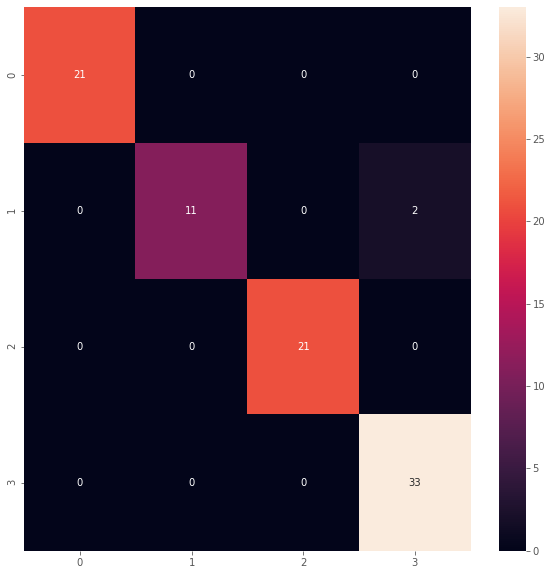

In [6]:
plots['Classification/Confusion Matrix']

### Embeddings

The gaussian assumptions on the embeddings are fulfilled.

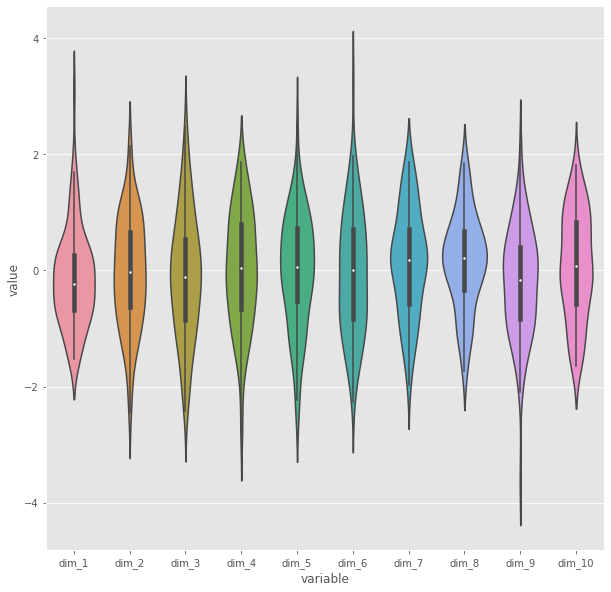

In [7]:
plots['Embeddings/Distributions']

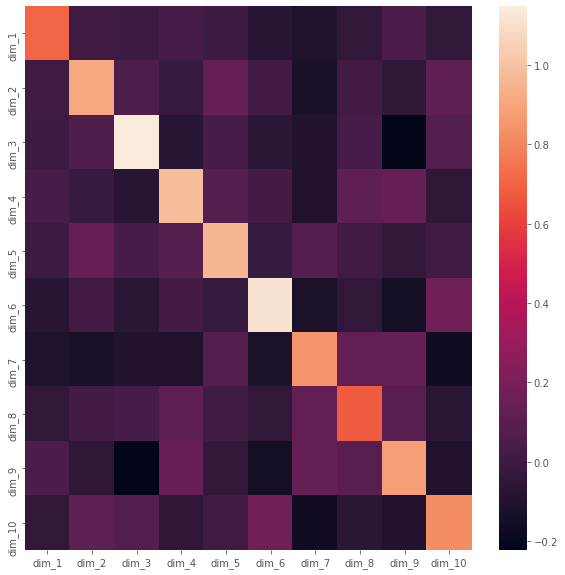

In [8]:
plots['Embeddings/Covariance']

### Reconstruction

The diagnostic plot for the reconstruction task of the autoencoder is much more problematic. Despite a heavy weight on the reconstruction task, a relatively large number of latent dimensions and a few hidden layers, the model is not able to reconstruct the original vector efficiently.

The 0 SNPs are being reconstructed well. Almost all of them are correctly recovered. However, it's far from the case for 1 and 2 SNPs. Most of the 1 SNPs are not recovered, they are reconstructed either as 0 or as 2. The case for 2 SNP is somewhat better are we recover correctly most of them correctly. 

The overall performance is not aweful but given the task that we wish to perform on the model we might need much more precision on the model.

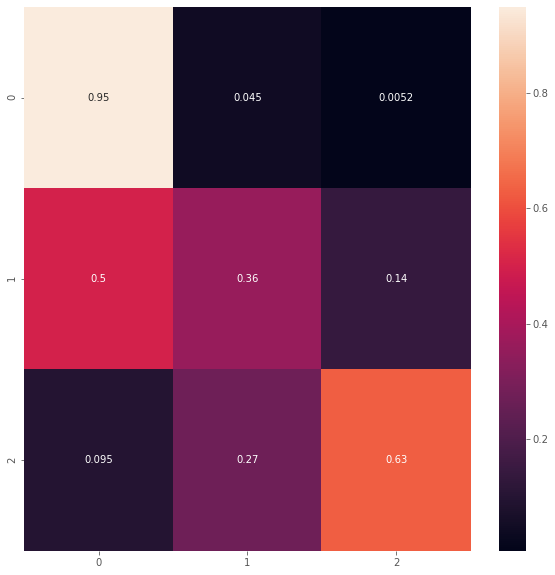

In [9]:
plots['Reconstruction/Confusion Matrix']

In order to visualize better how the model reconstruct a SNP, we need a detailed picture of how the model works. Rather than looking at the reconstructed SNPs alone, we can look at the classification scores of each SNP for each sample. Theses scores quantify the probability estimated by the model on each reconstruction. 

A way of doing so is to represent the SNPs on a ternary plot. Each vertex of the triangle is a possible value for the SNP (0, 1, 2). Each point on the triangle represent a SNP using the probabilities given by the decoder.

The closest a point is to a vertex, the more certain the model is. Points that are near the center or close to boundary lines are uncertain.

Additionnaly, we color SNP depending on its "true" value to understand where the model underperforms. Ideally we would want a confident model who reconstructs each SNP correctly.

In [10]:
from src.diagnostic_plots import plot_reconstruction_on_simplex, reconstruction_snp_df

output = autoencoder(x_val, c_val)

x_probas = nn.Softmax(dim=1)(output['decoder']['X_logits']).transpose(-1,1).detach().numpy()

reconstruction_df = reconstruction_snp_df(x_probas, x_val.flatten())

Below is a plot of the 2000 reconstructed SNP for a given sample.Results are similar to those on the reconstruction confusion matrix. Few zeros (blue) are misclassified, twos (green) are reconstructed fairly well but ones (red) are all over the triangle and almost none is recovered with confidence.

The plot is roughly similar for each sample.

In [11]:
plot_reconstruction_on_simplex(reconstruction_df.query('sample_id == 80'))

Instead of looking the reconstruction for a given sample, we can also look at reconstruction for a given snp. There is essentially two kinds of SNPs. Some SNPs (first plot) are reconstructed poorly with little confidence across all samples. Other SNPs (second plot) are reconstructed confidently but only the zeros SNP (the majority class) is recovered.

In [12]:
plot_reconstruction_on_simplex(reconstruction_df.query('sample_id == 39'))

In [13]:
plot_reconstruction_on_simplex(reconstruction_df.query('SNP_id == 154'))

From the above plots, we conclude that the model does not reconstruct the samples very accurately. Most of the ones  are not recovered properly and some twos are misclassified as ones. A reason for this lack of performance might lie in the random nature of SNPs.

Still, the model may captures some interesting properties in the data. Instead of comparing reconstruction and original data, we look at how a dataset sampled from the model compares to the original data. If the sampled distribution of SNPs has the same properties as the original, the model will be usefull.

# Sampled vs original distribution

We will now focus on distributions rather than individual samples. In fact, the reconstruction task itself is not the end goal. Instead, the model should recreate realistic populations. To check this, sampled and original data points are compared for different properties.

In [14]:
from src.sampling import sample_X_given_y_and_c
from src.diagnostic_plots import plot_SNP_corr, plot_allele_freq

X_sampled = sample_X_given_y_and_c(autoencoder, torch.nn.functional.one_hot(y_val.long()).float().squeeze(), c_val, argmax_categorical=False, center_z=False, mean_continuous=False)

X_sampled = pd.DataFrame(X_sampled)

X_val = pd.DataFrame(x_val.detach().numpy())

A first way to compare the distributions is to look at alleles frequencies for the overall population. The sampled set and testing set frequencies are very close. 

In [15]:
def get_frequencies(X):
    counts = np.unique(X, return_counts=True)[1]
    return counts / counts.sum()

print('Sampled set frequencies:', get_frequencies(X_sampled))
print('Testing set frequencies:', get_frequencies(X_val))

Sampled set frequencies: [0.75756818 0.14478977 0.09764205]
Testing set frequencies: [0.75926136 0.14508523 0.09565341]


Going into more details, we can compare the allele frequencies for each individual SNP. 

As can be seen below, the model reproduce the frequencies for each SNP with fidelity

In [16]:
plot_allele_freq(X_val, X_sampled)

A last property of the distribution to check is the correlation between SNPs. If samples from the model can produce a covariance matrix similar to those from the data, we will be able to draw conclusion from the model with more confidence.

In [17]:
plot_SNP_corr(X_val.iloc[:, 100:200], X_sampled.iloc[:, 100:200], A_name='val_set', B_name='sample_set')

/home/simon/anaconda3/lib/python3.7/site-packages/numpy/lib/function_base.py:2559: RuntimeWarning:

invalid value encountered in true_divide

/home/simon/anaconda3/lib/python3.7/site-packages/numpy/lib/function_base.py:2560: RuntimeWarning:

invalid value encountered in true_divide

/home/simon/anaconda3/lib/python3.7/site-packages/numpy/lib/function_base.py:2559: RuntimeWarning:

invalid value encountered in true_divide

/home/simon/anaconda3/lib/python3.7/site-packages/numpy/lib/function_base.py:2560: RuntimeWarning:

invalid value encountered in true_divide



# Identifying relevant SNPs


Now that we identified the limits of the model, we can use it to identify relevant SNPs in the distributions. In order to do so, we will proceed using the "counterfactual" analysis as performed in the application_MNIST notebook.
Because SNPs are not visual in nature, we instead analyze the average difference between the SNPs of the two groups. Then we check that the observed counter factual difference is linked to mutual information between SNPs and phenotype.

In [18]:
from src.counter_factuals import P_X_cat_counterfact_given_y_c, compute_categorical_average_effect
from src.sampling import outputs_given_z_c_y

In [19]:
def phenotype_counterfactual_analysis(case=0, c=c_val):
    '''
    Would be worth generalizing for categorical and continous phenotypes
    '''
    n_rep = 1
    y_A = torch.tensor([case] * c.shape[0] * n_rep)
    y_A = torch.nn.functional.one_hot(y_A.long(), num_classes=4).float().squeeze()
    c_A_B = torch.cat(n_rep * [c_val])


    ae_df = []
    for y_classe in [0, 1, 2, 3]:    
        y_B = torch.tensor([y_classe] * c.shape[0] * n_rep).reshape(-1, 1)
        y_B = torch.nn.functional.one_hot(y_B.long(), num_classes=4).float().squeeze()
        counterfact_probas = P_X_cat_counterfact_given_y_c(autoencoder, [(y_A, c_A_B), (y_B, c_A_B)])
        ae = compute_categorical_average_effect(counterfact_probas)
        ae['rsid'] = X_val.columns
        ae = ae.rename(columns={'ae 0-1': 'JSD'}).assign(diff_case_control=f'{case}-{y_classe}')
        ae_df.append(ae)

    return pd.concat(ae_df)

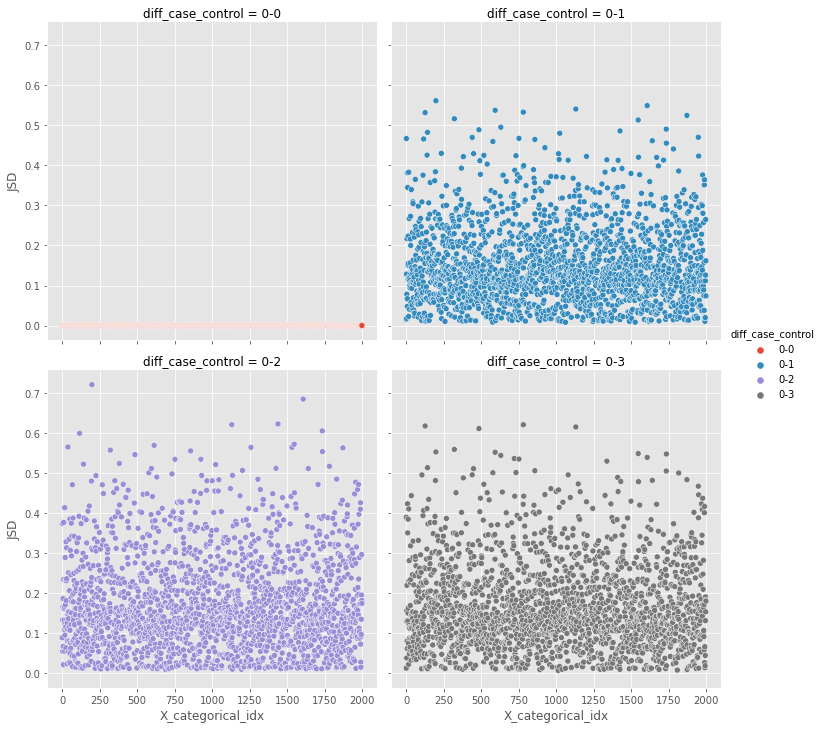

In [20]:
ae_df = phenotype_counterfactual_analysis(case=0)

sns.relplot(data=ae_df, x='X_categorical_idx', y='JSD', hue='diff_case_control', col="diff_case_control", col_wrap=2)

/home/simon/anaconda3/lib/python3.7/site-packages/scipy/spatial/distance.py:1287: RuntimeWarning:

invalid value encountered in sqrt



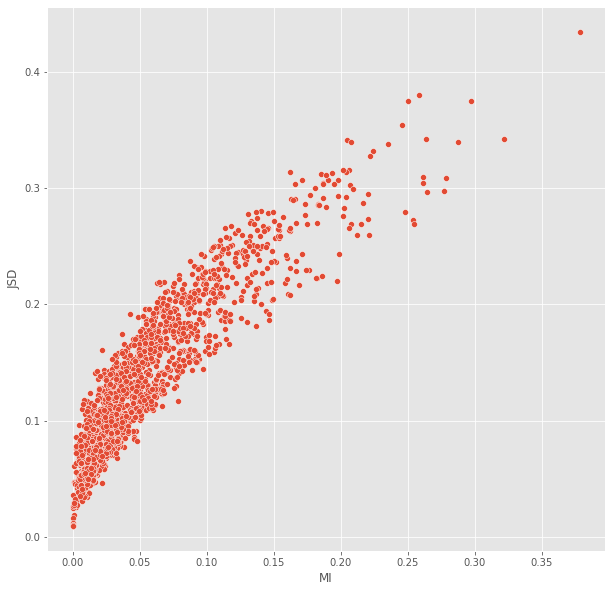

In [21]:
from sklearn.metrics.cluster._supervised import mutual_info_score

def MI_JSD_comp():

    ae_df = pd.concat([phenotype_counterfactual_analysis(case=i).query('JSD != 0') for i in range(4)])

    MI_by_dim = np.apply_along_axis(lambda x: mutual_info_score(x, y.flatten()), 0, X)

    MI_by_dim = pd.DataFrame(MI_by_dim, columns=['MI']).assign(X_categorical_idx=range(2000))

    plot_df = MI_by_dim.merge(ae_df.groupby('X_categorical_idx')['JSD'].mean().reset_index(), on='X_categorical_idx')
    
    return plot_df

plot_df = MI_JSD_comp()

fig, ax = plt.subplots(figsize=(10, 10))
sns.scatterplot(data=plot_df, x='MI', y='JSD', ax=ax)
plt.show()

This graph shows that the SNPs with the highest average effects are also the SNPs that have a high mutual information with the phenotype of interest.